# 1) Setup

In [7]:
!python -V

Python 3.8.3


In [8]:
pip install pymongo

Note: you may need to restart the kernel to use updated packages.


In [9]:
pip install pymongo[srv]

Note: you may need to restart the kernel to use updated packages.


## 1a) Modules

In [82]:
import pandas as pd
import matplotlib.pyplot as plt
import scipy as sp
import numpy as np

import pymongo
from pymongo import MongoClient
from datetime import datetime
print("done")

done


## 1b) Retrieve Data from MongoDB

In [69]:
#define my database and collection
cluster = MongoClient("mongodb://127.0.0.1:27017/?readPreference=primary&appname=MongoDB%20Compass&ssl=false")
db = cluster["Rokos2021"]
collection = db["walmart_targeted"]
print("done")

done


In [70]:
#filter & store as pandas dataframe
results = collection.find({"_meta.inserted_at": {"$gte": datetime(2021,2,20,9,0,0),
                                "$lte":datetime(2021,2,28,9,0,0)}, 
                                "origin": {"$ne": None}, 
                                "edge_id": {"$ne": None}, 
                                "target":{"$ne":None},
                                "succeeded":True})

#convert to dataframe format
df = pd.DataFrame(list(results))
print("done")


done


In [71]:
#show dataframe
df.head(2)

,_id,origin,target,succeeded,run_id,date_finished,policy_goal,agent,_meta,is_final,edge_id,action,date_started,operation_time,topological_map,final_node
0,60355f5ae58b9f729ea1d688,WayPoint112,WayPoint82,True,b09bd134-ea6f-44bc-80fe-53d3dd41f62e,1970-01-01 00:00:12.801,WayPoint60,/robot_2/rapport_navigation,{'inserted_at': 2021-02-23 20:02:34.101000},False,WayPoint112_WayPoint82,move_base,1970-01-01 00:00:07.609,5.192,walmart,WayPoint82
1,60355f5a0c5936f239914148,WayPoint113,WayPoint89,True,b09bd134-ea6f-44bc-80fe-53d3dd41f62e,1970-01-01 00:00:12.921,WayPoint95,/robot_3/rapport_navigation,{'inserted_at': 2021-02-23 20:02:34.448000},False,WayPoint113_WayPoint89,move_base,1970-01-01 00:00:07.801,5.120,walmart,WayPoint89


# 1c) Select data

In [72]:
#remove data where policy_goal = target
#we previously removed null & unsuccessful entries
df = df[ df["policy_goal"] != df["target"] ]
df.head(2)

,_id,origin,target,succeeded,run_id,date_finished,policy_goal,agent,_meta,is_final,edge_id,action,date_started,operation_time,topological_map,final_node
0,60355f5ae58b9f729ea1d688,WayPoint112,WayPoint82,True,b09bd134-ea6f-44bc-80fe-53d3dd41f62e,1970-01-01 00:00:12.801,WayPoint60,/robot_2/rapport_navigation,{'inserted_at': 2021-02-23 20:02:34.101000},False,WayPoint112_WayPoint82,move_base,1970-01-01 00:00:07.609,5.192,walmart,WayPoint82
1,60355f5a0c5936f239914148,WayPoint113,WayPoint89,True,b09bd134-ea6f-44bc-80fe-53d3dd41f62e,1970-01-01 00:00:12.921,WayPoint95,/robot_3/rapport_navigation,{'inserted_at': 2021-02-23 20:02:34.448000},False,WayPoint113_WayPoint89,move_base,1970-01-01 00:00:07.801,5.120,walmart,WayPoint89


In [73]:
# remove every column except: origin, target, edge_id, operation_time
df = df.loc[:,["origin", "target", "edge_id", "operation_time"]]
df.head(2)

,origin,target,edge_id,operation_time
0,WayPoint112,WayPoint82,WayPoint112_WayPoint82,5.192
1,WayPoint113,WayPoint89,WayPoint113_WayPoint89,5.120


In [157]:
#select all entries between the same origin-target pair
waypoint_1 = "WayPoint69"
waypoint_2 = "WayPoint70"
subset = df.loc[df["origin"].isin([waypoint_1, waypoint_2]) & df["target"].isin([waypoint_1, waypoint_2]), ["edge_id", "operation_time"]]
print(subset.shape)
subset.head()

(751, 2)


,edge_id,operation_time
345,WayPoint69_WayPoint70,10.328
353,WayPoint69_WayPoint70,12.461
356,WayPoint69_WayPoint70,10.403
363,WayPoint69_WayPoint70,8.602
380,WayPoint69_WayPoint70,13.989


## 1d) Visualisation

In [158]:
subset.describe()

,operation_time
count,751.000000
mean,12.154848
std,3.381275
min,8.559000
25%,10.153000
50%,10.891000
75%,13.132500
max,38.456000


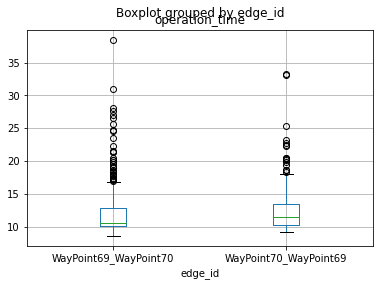

In [159]:
subset.boxplot(column = "operation_time", by = "edge_id")

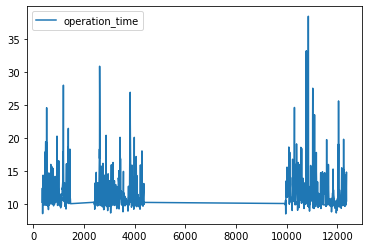

In [160]:
subset.plot()

# 2 Duration Distributions

## 2a) Gaussian
- Gives non-zero probability to impossible events

### 2ai) Frequentist approach

In [161]:
def Gaussian_ml(t):
    "Calculate max. likelihood estimators"
    N = len(t)
    mean_ml = (1/N) * sum(t)
    var_ml = (1/N) * sum((t - mean_ml)**2)
    return mean_ml, var_ml

In [162]:
def Gaussian_freq(x,mean,var):
    "Calculate gaussian distribution - frequentist approach"
    return ( 1/ ((2*np.pi*var)**0.5) )*np.exp( (-1/(2*var)) * np.square(x-mean) )

In [163]:
#find mean & variance
t_op = subset["operation_time"]
mean_ml, var_ml = Gaussian_ml(t_op)
print(mean_ml, var_ml)

12.154848202396785 11.41779364140491


In [164]:
# calculate distribution
t_start= 0
t_stop = (np.max(t_op)//5)*5 + 5    #round up to nearest 5 secs
t_step = 0.01
t = np.arange(t_start,t_stop,t_step)
p = Gaussian_freq(t,mean_ml,var_ml)

Text(0.5, 1.0, 'WayPoint69_WayPoint70')

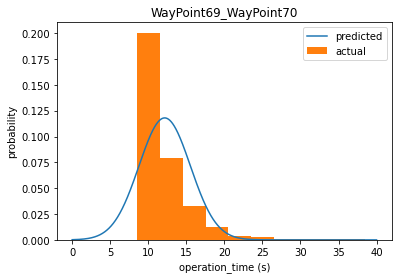

In [169]:
plt.plot(t,p)
plt.hist(t_op, density = True)
plt.legend(["predicted","actual"])
plt.xlabel("operation_time (s)")
plt.ylabel("probability")
plt.title(subset.iloc[0,0])

### 2aii) Frequentist Approach - sequential???

### 2aiii) Bayesian Approach - simple
- Assume var known, mean unknown
- estimate var using MLE

In [209]:
#prior
def prior_1(mean, mean_0, var_0):
    "mean is a guess. mean_0 & var_0 are parameters"
    return Gaussian_freq(mean,mean_0,var_0)



In [219]:
def likelihood_1(t,mean):
    var = (1/N) * np.sum((t - mean)**2)
    log_likelihood = 0
    for n in range(len(t)):
        likelihood = Gaussian_freq(t.iloc[n],mean,var)
        log_likelihood += np.log(likelihood)
    return log_likelihood


%timeit prior_1(13,12,12)
%timeit likelihood_1(t_op,13)
np.exp(likelihood_1(t_op,13))*prior_1(13,12,12)

4.63 µs ± 439 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
8.86 ms ± 88.8 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


0.0

In [216]:
t_start= 0
t_stop = (np.max(t_op)//5)*5 + 5    #round up to nearest 5 secs
t_step = 0.01
mu = np.arange(t_start,t_stop,t_step)
print(mu, len(mu))


[0.000e+00 1.000e-02 2.000e-02 ... 3.997e+01 3.998e+01 3.999e+01] 4000


In [222]:
mean_0 = 12
var_0 = 12
prior_list = []
likelihood_list = []
for m in mu:
    prior_list.append(prior_1(m,mean_0,var_0))
    likelihood_list.append(likelihood_1(t_op,m))
print("done")

done


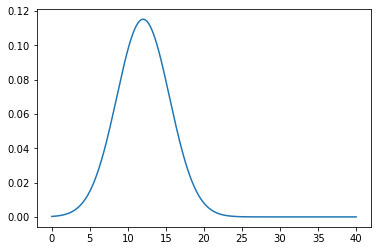

In [225]:
plt.plot(mu,prior_list)

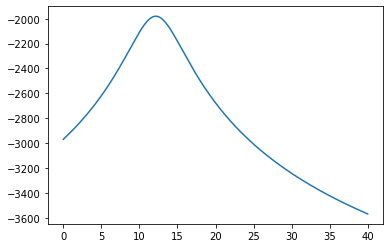

In [226]:
plt.plot(mu,likelihood_list)

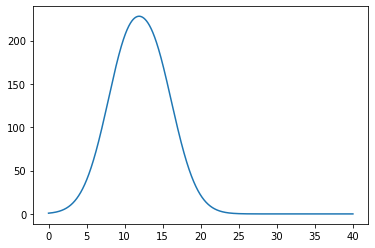

In [234]:
#WRONG posterior
#posterior = log(normal) likelihood * normal prior
posterior_list = np.multiply(prior_list,np.abs(likelihood_list))
plt.plot(mu,posterior_list)

0.01 2186.3103789104634


Text(0.5, 1.0, 'WayPoint69_WayPoint70')

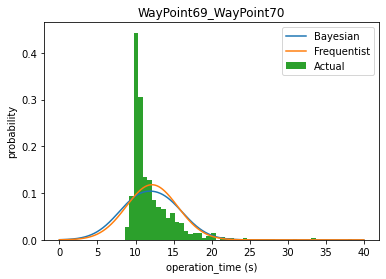

In [248]:
#normalise a distribution
spacing = mu[1]-mu[0]
norm_const = spacing * np.sum(posterior_list)
print(spacing, norm_const)
plt.plot(mu,posterior_list/norm_const)
plt.plot(t,p)
plt.hist(t_op, density = True, bins = 50)
plt.legend(["Bayesian", "Frequentist","Actual"])
plt.xlabel("operation_time (s)")
plt.ylabel("probability")
plt.title(subset.iloc[0,0])

(array([0.17724195, 0.26586292, 0.48741535, 0.70896779, 3.72208088,
        4.03225428, 4.9627745 , 2.21552433, 2.17121384, 1.28500411,
        1.68379849, 1.24069363, 0.93052022, 0.97483071, 0.93052022,
        1.01914119, 0.53172584, 0.84189925, 0.84189925, 0.62034681,
        0.6646573 , 0.26586292, 0.35448389, 0.22155243, 0.31017341,
        0.31017341, 0.08862097, 0.17724195, 0.31017341, 0.        ,
        0.13293146, 0.08862097, 0.08862097, 0.08862097, 0.        ,
        0.08862097, 0.08862097, 0.04431049, 0.08862097, 0.04431049,
        0.        , 0.        , 0.04431049, 0.        , 0.        ,
        0.08862097, 0.        , 0.        , 0.        , 0.04431049]),
 array([2.14698336, 2.17703399, 2.20708462, 2.23713524, 2.26718587,
        2.2972365 , 2.32728713, 2.35733775, 2.38738838, 2.41743901,
        2.44748963, 2.47754026, 2.50759089, 2.53764152, 2.56769214,
        2.59774277, 2.6277934 , 2.65784403, 2.68789465, 2.71794528,
        2.74799591, 2.77804654, 2.80809716, 2.

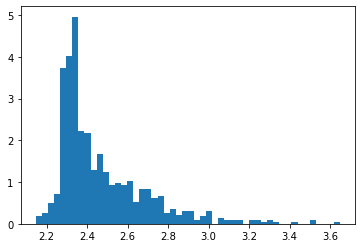

In [262]:
t_log = np.log(t_op)

plt.hist(t_log, density = True, bins = 50)